In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

import json

from math import tau

In [122]:
_, trace, trace_labels, label2index, timestamps = traces.load_trace()
timestamps = timestamps - timestamps[0]

chemical, gapjn = connectomes.load_cook_connectome()
neurons = connectomes.get_main_neurons(chemical, gapjn)
neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)

not_in_main_section = [label2index[key] for key in label2index if key not in neurons]
not_labelled = [i for i, _ in enumerate(trace[:, 0]) if i not in label2index.values()]

removal = list(set(not_in_main_section).union(not_labelled))

trace = np.delete(trace, removal, axis=0)

In [3]:
with open("rust/results/d_bio_sens_dt_00001.json", "r") as file:
    small = np.array(json.load(file))

with open("rust/results/d_bio_sens_dt_001.json", "r") as file:
    med = np.array(json.load(file))

with open("rust/results/d_bio_sens_dt_01.json", "r") as file:
    large = np.array(json.load(file))

with open("rust/results/d_bio_sens_dt_1.json", "r") as file:
    huge = np.array(json.load(file))

with open("rust/processed_data/sensory_indices.json", "r") as file:
    sensory_indices = json.load(file)

datas = [small, med, large, huge]

In [4]:
def side_comp(datas, count = 32, per = 8, stride=1, ymin=-50, ymax=5):

    rows = int(np.ceil(count / per))

    fig, axs = plt.subplots(ncols=len(datas), nrows=rows, figsize=(5*12, 5*12))

    for ax in axs.flatten().tolist():
        ax.set_ylim([ymin, ymax])

    ax_index = -1
    
    # Voltage time curves
    for i in range(count):
        if i % per == 0:
            ax_index += 1
        for j, data in enumerate(datas): 
            if i in sensory_indices:
                axs[ax_index, j].plot(data[::stride, i], label=f'V_m_{i}', marker='^')
            else:
                axs[ax_index, j].plot(data[::stride, i], label=f'V_m_{i}')
            
        
    plt.show()

In [5]:
def show_large_voltage_data(data, count = None, per = 8.0, stride=1):
    
    if count is None:
        pass
    else:
        data = data[:, :count]

    size = int(np.ceil(np.sqrt(data.shape[1] / per)))

    fig, axs = plt.subplots(ncols=size, nrows=size, figsize=(5*12, 5*12))

    ax_index = -1
    
    # Voltage time curves
    for i in range(data.shape[1]):
        if i % per == 0:
            ax_index += 1

        if i in sensory_indices:
            axs[ax_index // size, ax_index % size].plot(data[::stride, i], label=f'V_m_{i}', marker='^')
        else:
            axs[ax_index // size, ax_index % size].plot(data[::stride, i], label=f'V_m_{i}')
        
        
    plt.show()

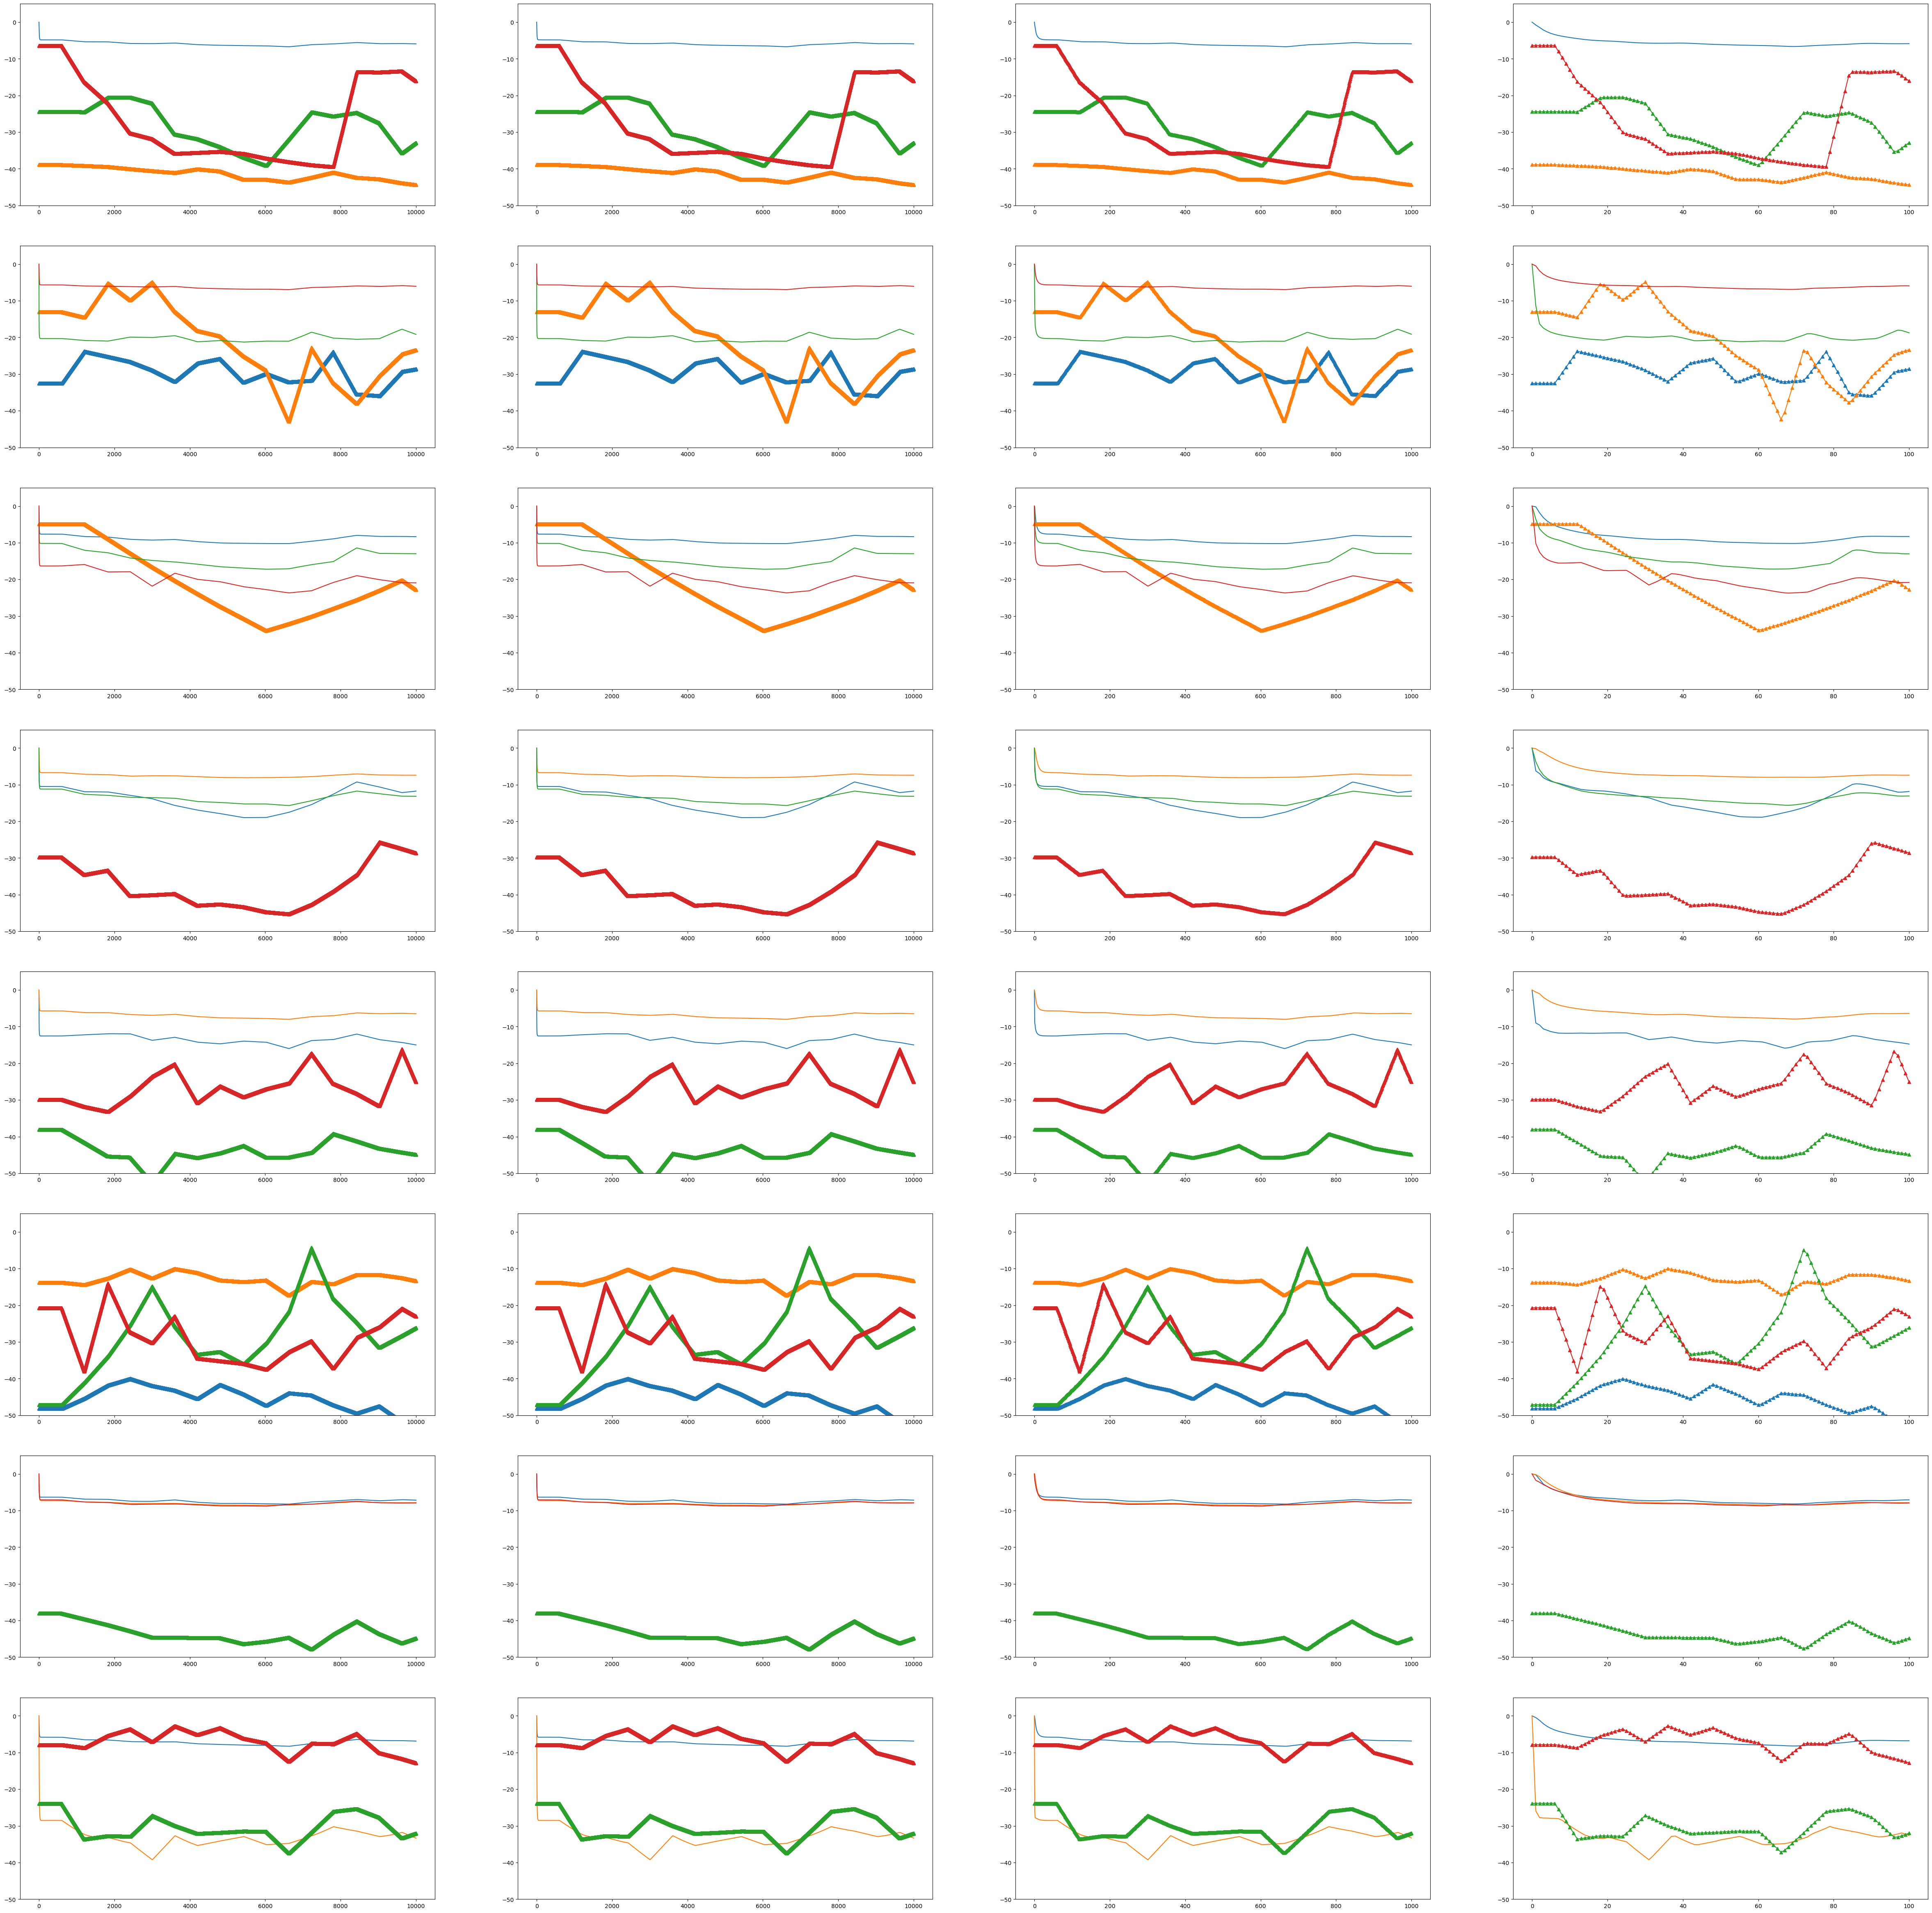

In [16]:
side_comp(datas, per=4)

In [117]:
trace.shape

(152, 1600)

In [118]:
small.shape

(10001, 280)

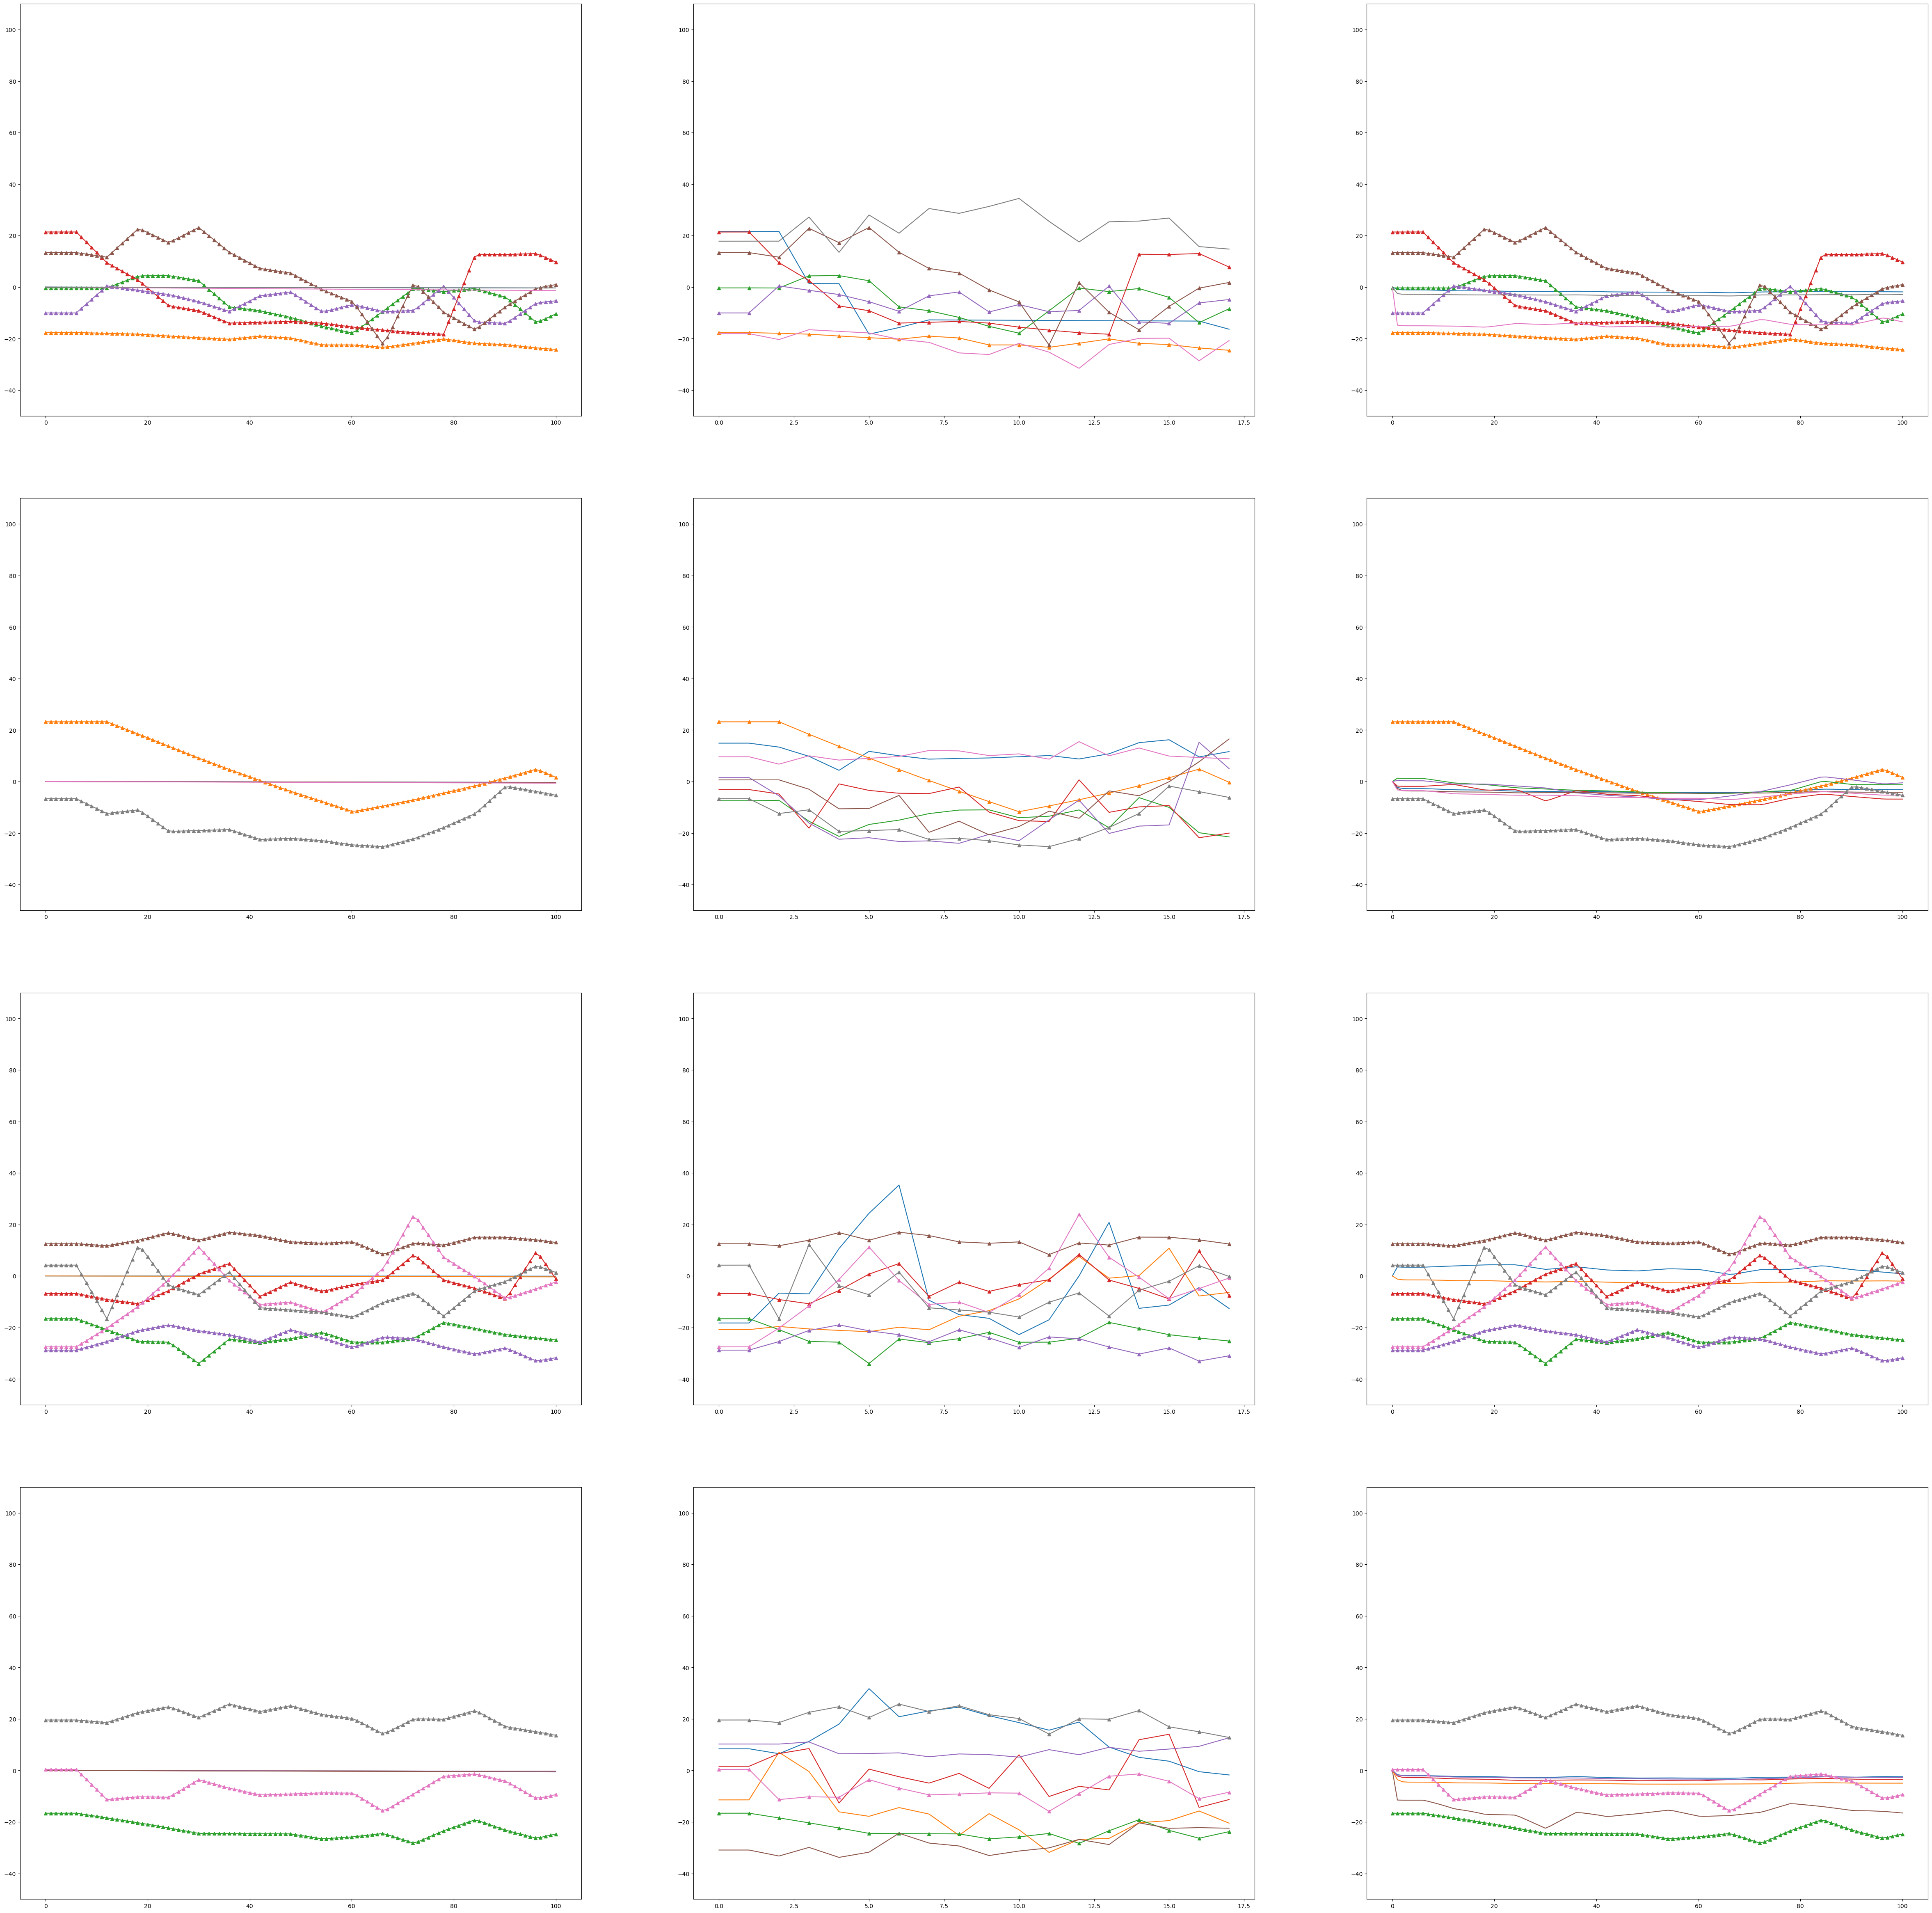

In [162]:
with open("rust/results/tmp_runs_new.json", "r") as file:
    data = np.array(json.load(file))

with open("rust/results/tmp_can_delete.json", "r") as file:
    old_data = np.array(json.load(file))

mod_trace = 12.0 * trace.T[:18, :] - 13.0
og_mod_trace = 10.0 * trace.T[:18, :] - 35.0

side_comp([data, mod_trace, old_data], ymax=110)

In [149]:
with open("rust/results/preprocessing_tests_with_calc_gates.json", "r") as file:
    data = np.array(json.load(file))

data = np.nan_to_num(data.astype(np.float64), nan=5000)

In [150]:
data[:, 2]

array([3464.60556023, 3463.51664306, 3462.45241643, ..., 5834.39229255,
       5863.97963583, 5893.74401688])

In [151]:
data[21887]

array([   9.       ,  -13.       , 3276.8853152])

In [152]:
data[:, 2].max()

8958561.347366704

In [153]:
data[:, 2].argmin()

21887

In [154]:
data[:, 2].min()

3276.8853152025504

In [155]:
slice = data[:, 2].reshape(200, 200)
slice.shape

(200, 200)

In [156]:
slice

array([[3464.60556023, 3463.51664306, 3462.45241643, ..., 3533.64749436,
        3538.97674166, 3544.44768708],
       [3465.38599988, 3464.26902127, 3463.17559743, ..., 3539.38926648,
        3544.92000397, 3550.5966708 ],
       [3466.19360487, 3465.04930424, 3463.92735279, ..., 3545.40280163,
        3551.14355594, 3557.03457499],
       ...,
       [3393.90852365, 3392.06618596, 3390.28556194, ..., 5894.37030668,
        5924.93716145, 5955.68754056],
       [3392.34278515, 3390.580323  , 3388.88067919, ..., 5863.98304561,
        5894.05350394, 5924.30418897],
       [3390.8696208 , 3389.18632447, 3387.5668675 , ..., 5834.39229255,
        5863.97963583, 5893.74401688]])

<Axes: >

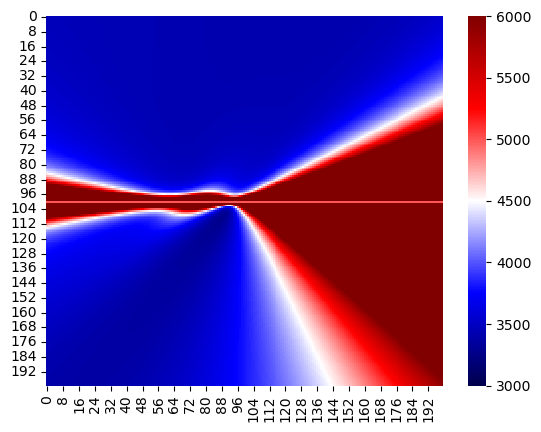

In [159]:
sns.heatmap(slice, vmin=3000.0, vmax=6000, cmap="seismic")